In [1]:
import os
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.text import Text
import seaborn as sns; sns.set_style("white")
import matplotlib as mpl
# import umap.plot
from sklearn.decomposition import PCA

from scipy.stats import pearsonr

%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1/3_Figure2/RemoveNoise')
print(os.getcwd())


cell_line = "HCT116"



/share/data/analyses/christa/colopaint3D/spher_colo52_v1/3_Figure2/RemoveNoise
/share/data/analyses/christa/colopaint3D/spher_colo52_v1/3_Figure2/RemoveNoise


In [2]:
def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))
def inverse_pDose(y):
    '''Inverse function of pDose'''
    return 10**(-y) / 1e-6
def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    return list_of_selected_features

In [3]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [4]:
# Load the data

# file = '1_Data/results/normalized_data_HCT116.csv' # Old file with slice normalization
# file = '1_Data/results/normalized_data_no_slice_HCT116.csv' # Old file without slice normalization
file = '/home/jovyan/share/data/analyses/christa/colopaint3D/spher_colo52_v1/1_Data/results/normalized_data_merged_HCT116.csv'
data = pd.read_csv(file)
data = data.query('Metadata_name == "dmso"')
cmap = sns.color_palette("YlOrRd",
                         n_colors=len(data['Metadata_Site'].unique()))

In [5]:
# Calculate the PCA embedding
training_data = data.loc[:, list_features(data)].values
# Perform PCA
pca = PCA(n_components=2)
pca.fit(training_data)
embedding= pca.transform(training_data)

variance_explained = pca.explained_variance_ratio_ * 100  # Convert to percentage


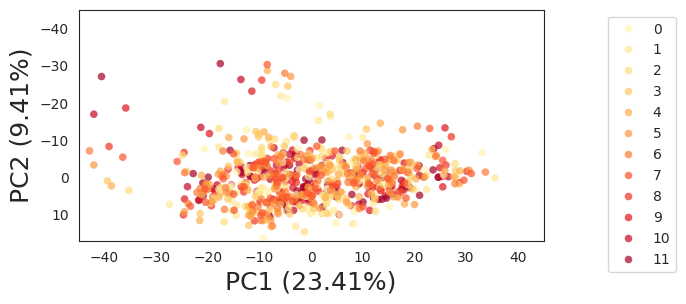

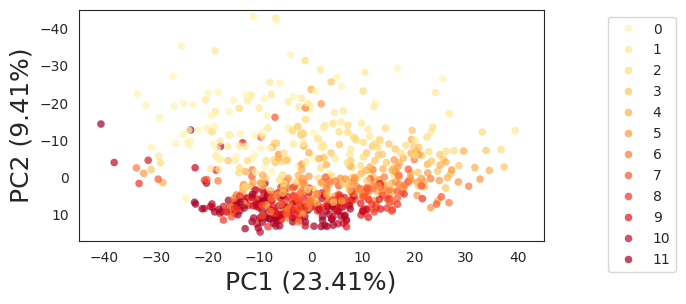

In [22]:
norm_categories = data['Metadata_normalization'].unique()


for cat in norm_categories:

    subset_mask = data['Metadata_normalization'] == cat
    embedding1 = embedding[subset_mask]
    data1 = data[subset_mask]

    ## Pathways
    ## PCA - Pathway
    fig = plt.figure(figsize=(6, 3))
    ax = sns.scatterplot(
        x=embedding1[:, 0],
        y=embedding1[:, 1],
        hue=data1.Metadata_Site,
        alpha=(0.7),
        marker="o",
        palette=cmap,
        s=30,
        edgecolor='none',
        #size=df_toplot["Metadata_cmpd_conc"],
        #palette=pal,
        #legend=False
    )
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')

    # Add variance explained to axis labels
    plt.xlabel(f'PC1 ({variance_explained[0]:.2f}%)', size=18)
    plt.ylabel(f'PC2 ({variance_explained[1]:.2f}%)', size=18)


    plt.xlim(-45, 45)
    plt.ylim(-45, 17)

    plt.gca().invert_yaxis()

    # plt.title('Slices - norm' + ' - ' + cell_line)
    plt.show()

    fig.savefig("PCA_aggregates_{}_{}.{}".format(cat, cell_line, figformat),
                dpi=dpi,
                bbox_inches="tight")

In [7]:
# Correlation analysis between PC1 and slice number

for cat in norm_categories:
    subset_mask = data['Metadata_normalization'] == cat
    embedding_part = embedding[subset_mask]
    data_part = data[subset_mask]

    slice_info = data_part.loc[data_part.index, 'Metadata_Site']  # Which slice each point is from

    # Calculate correlation
    correlation, p_value = pearsonr(embedding_part[:, 1], slice_info)  # PC1 vs slice number

    print(f"Correlation between PC2 and slice: {correlation:.2f}")
    print(f"P-value: {p_value}")

# Report this inside the figure 

Correlation between PC2 and slice: -0.00
P-value: 0.9999999999982924
Correlation between PC2 and slice: 0.76
P-value: 1.816201952353938e-133


In [10]:
import numpy as np
from scipy.stats import f_oneway

for cat in norm_categories:
    subset_mask = data['Metadata_normalization'] == cat
    embedding_part = embedding[subset_mask]
    data_part = data[subset_mask]

    # Get the data
    slice_info = data_part.loc[data_part.index, 'Metadata_Site'].values
    pc2_values = embedding_part[:, 1]

    # Calculate variance explained by slice (manual ANOVA)
    # Total sum of squares
    total_mean = np.mean(pc2_values)
    total_ss = np.sum((pc2_values - total_mean) ** 2)

    # Between-group sum of squares (explained by slice)
    unique_slices = np.unique(slice_info)
    between_ss = 0

    for slice_num in unique_slices:
        slice_mask = slice_info == slice_num
        slice_values = pc2_values[slice_mask]
        slice_mean = np.mean(slice_values)
        n_samples = len(slice_values)
        between_ss += n_samples * (slice_mean - total_mean) ** 2

    # Within-group sum of squares (residual)
    within_ss = total_ss - between_ss

    # Calculate percentage
    pct_explained_by_slice = (between_ss / total_ss) * 100
    pct_residual = (within_ss / total_ss) * 100

    print("=" * 50)
    print("VARIANCE PARTITION - PC2")
    print("=" * 50)
    print(f"Variance explained by Slice: {pct_explained_by_slice:.1f}%")
    print(f"Residual variance: {pct_residual:.1f}%")

    # Optional: F-test for significance
    groups = [pc2_values[slice_info == s] for s in unique_slices]
    f_stat, p_value = f_oneway(*groups)
    print(f"\nF-statistic: {f_stat:.2f}")
    print(f"P-value: {p_value:.3e}")

    if pct_explained_by_slice > 30:
        print("\n→ Strong evidence for slice-related artifacts!")
    elif pct_explained_by_slice > 15:
        print("\n→ Moderate slice effect detected")
    else:
        print("\n→ Weak slice effect")

VARIANCE PARTITION - PC2
Variance explained by Slice: 0.0%
Residual variance: 100.0%

F-statistic: 0.00
P-value: 1.000e+00

→ Weak slice effect
VARIANCE PARTITION - PC2
Variance explained by Slice: 65.5%
Residual variance: 34.5%

F-statistic: 117.93
P-value: 8.116e-150

→ Strong evidence for slice-related artifacts!
